本文主要以kaggle一次二分类竞赛数据为例，深入研究改进forest

- 数据地址：https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- 数据特点：
  - 非常不均衡、缺失值严重、二分类
- 包含内容：
  1. 数据获取
  2. 模型应用
  3. 结果分析

# Stage-1：获取数据

In [1]:
import os
import numpy as np
import pandas as pd
import time

In [2]:
df_train = pd.read_csv('./datasetes/driver/train.csv')
df_test = pd.read_csv('./datasetes/driver/test.csv')

In [3]:
print(df_train[df_train.target==1].shape)
print(df_train[df_train.target==0].shape)
21694/573518

(21694, 59)
(573518, 59)


0.037826188541597645

In [4]:
target_train = df_train['target'].values
id_train = df_train['id'].values
id_test = df_test['id'].values

In [5]:
df_train = df_train.drop(['target','id'],axis=1)
df_test = df_test.drop(['id'], axis = 1)
# combine = pd.concat([df_train,df_test],axis=0)

In [6]:
print ("The train shape is:",df_train.shape)
print ('The test shape is:',df_test.shape)
# print ('The combine shape is:',combine.shape)

The train shape is: (595212, 57)
The test shape is: (892816, 57)


# Stage-2：模型应用

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
train = np.array(df_train)
test = np.array(df_test)
X = train
y = target_train

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=9487)
split_obj = tuple(sss.split(X, y))
train_index, test_index = split_obj[0]
X_train, X_valid = X[train_index], X[test_index]
y_train, y_valid = y[train_index], y[test_index]

In [10]:
t_y_train = np.array([[item] for item in y_train])
mask_y_train_1 = np.where(np.any(t_y_train==1, axis=1))[0]
mask_y_train_0 = np.where(np.any(t_y_train==0, axis=1))[0]

In [11]:
mask_y_train_1.shape, mask_y_train_0.shape

((18440,), (487490,))

In [12]:
# X_train = X_train[mask_y_train_1]
print(X_train.shape)
mask_y_train_batch = mask_y_train_0[:len(mask_y_train_1)]
X_train = np.vstack((X_train[mask_y_train_1], X_train[mask_y_train_batch]))
print(X_train.shape)

(505930, 57)
(36880, 57)


In [13]:
# X_train = X_train[mask_y_train_1]
print(y_train.shape)
mask_y_train_batch = mask_y_train_0[:len(mask_y_train_1)]
y_train = np.hstack((y_train[mask_y_train_1], y_train[mask_y_train_batch]))
print(y_train.shape)

(505930,)
(36880,)


In [14]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [15]:
print(X_train.shape, y_train.shape)

(36880, 57) (36880,)


In [16]:
clf = RandomForestClassifier(max_depth=10, random_state=1024, n_jobs=8,  min_samples_leaf=100, max_leaf_nodes=100,
                                 n_estimators=2, verbose=1, oob_score=True, #boostrap=False,
                                 criterion='gini')
clf = clf.fit(X_train, y_train)
    
p_valid = clf.predict_proba(X_valid)
p_valid = [item[1] for item in p_valid]
p_valid = np.array(p_valid)
print(gini_normalized(y_valid, p_valid))
    
# Predict on our test data
p_test = clf.predict_proba(test)
p_test = [item[1] for item in p_test]
p_test = np.array(p_test)

p_train = clf.predict_proba(train)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print(gini_normalized(y, p_train))

[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.0s finished
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\program files\python36\lib\site-packages\sklearn\ensemble\forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


0.210488915017


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


0.230860686011


In [17]:
clf.apply(X_train)

[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:    0.0s finished


array([[100, 134],
       [156, 103],
       [139,  99],
       ..., 
       [138,  99],
       [165,  99],
       [103, 103]], dtype=int64)

In [18]:
clf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features='auto', max_leaf_nodes=100,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=100, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=634329019, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features='auto', max_leaf_nodes=100,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=100, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1825252241, splitter='best')]

# Stage-3：结果分析

In [42]:
import ForestUtils
import graphviz 
from sklearn import tree
import importlib
from sklearn.utils import check_random_state

In [35]:
importlib.reload(ForestUtils)

<module 'ForestUtils' from 'C:\\github_workspace\\LayerForest\\ForestUtils.py'>

In [61]:
estimator = clf.estimators_[0]

In [118]:
dot_data = tree.export_graphviz(estimator, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("./output/driver") 

'./output/driver.pdf'

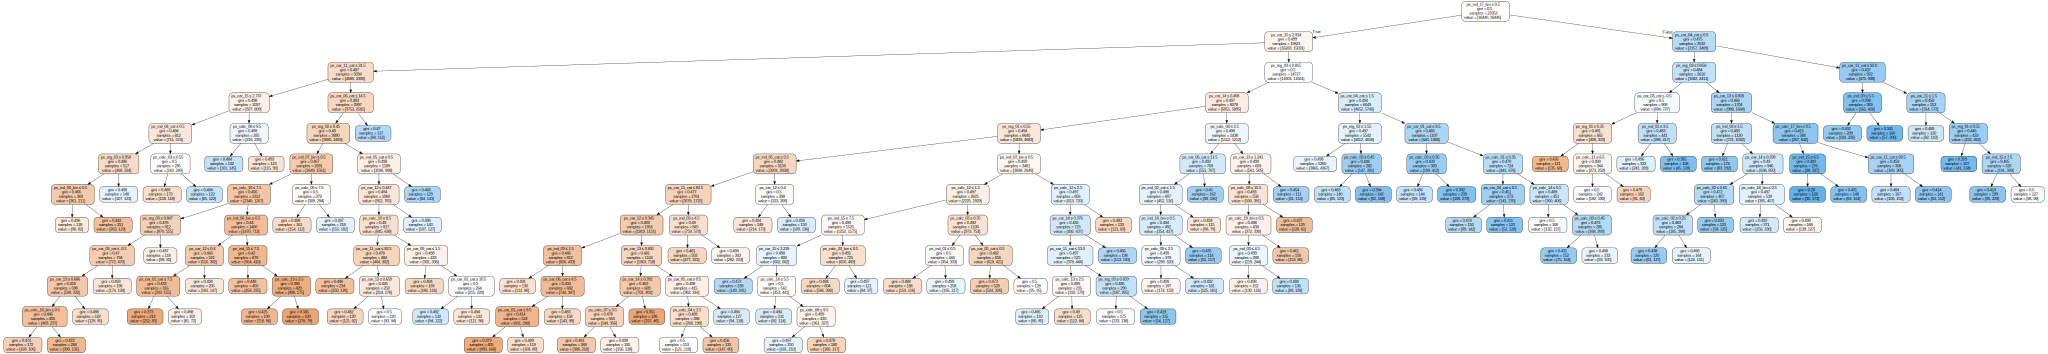

In [117]:
dot_data = tree.export_graphviz(estimator, out_file=None, 
                         feature_names=df_train.columns,  
#                          class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## 结果gini排序并显示

In [43]:
# def _generate_sample_indices(random_state, n_samples):
#     """Private function used to _parallel_build_trees function."""
#     random_instance = check_random_state(random_state)
#     sample_indices = random_instance.randint(0, n_samples, n_samples)

#     return sample_indices


# def _generate_unsampled_indices(random_state, n_samples):
#     """Private function used to forest._set_oob_score function."""
#     sample_indices = _generate_sample_indices(random_state, n_samples)
#     sample_counts = np.bincount(sample_indices, minlength=n_samples)
#     unsampled_mask = sample_counts == 0
#     indices_range = np.arange(n_samples)
#     unsampled_indices = indices_range[unsampled_mask]

#     return unsampled_indices

In [62]:
# random_state = 1024
# n_samples = X_train.shape[0]
# indices = _generate_sample_indices(random_state, n_samples)

In [73]:
# 对于一个决策树返回所有叶子节点的gini排序
impurity = estimator.tree_.impurity # 所有节点的不纯度
threshold = estimator.tree_.threshold
impurity_index = np.argsort(impurity, axis=0)  
impurity_index

array([ 12,  82, 102, 105, 138, 162,  26, 124, 163,  56, 196,  94,  69,
        24, 113,  68,  74, 135, 104, 116,  21, 156, 180,  40, 178,  60,
       106, 130,  75, 183, 122, 154,  16,  28,  85,  43,  78, 161, 190,
        99, 137, 143,  89, 139,  46, 120, 170,  37, 112,  58, 188, 171,
       145, 103,  97, 148, 164,  33, 153,   8,  18, 109, 101,  73, 132,
        42,  95, 123, 107, 195,  35,  64,  98,  31,  83, 173, 157,   3,
        87, 136,  19, 191, 155,  10,  11, 133,  49,  72, 151,  39, 198,
        79, 172, 176,  81,  47, 127,  59,  65,  55, 146, 149,  30,  48,
        76,  14,   5, 160, 185, 115, 126,   2,  93, 167, 193, 142,  67,
       100, 184, 117,   9, 182, 118, 177,  53, 119,  61,  57, 159, 150,
        88, 129, 194,  23,  96,  27,  91,  62, 181,  20,  34,  80,  70,
        51,  92, 165,   4,  44, 134, 168,  38,  66, 189,  36, 166,  45,
         1, 108, 114, 147, 144, 179,   7,  15,  54, 111,  29, 187,  71,
        25, 121,  32,  86, 175,  52,  84, 174, 169,  22,  63, 14

In [141]:
for id in impurity_index:
    if threshold[id] != -2: continue
    ForestUtils.print_node_info(estimator, id)
    for item in X_train:
        sample_list = [item]
        leave_id = estimator.apply(sample_list)[0]
        if leave_id == id:
            ForestUtils.print_decision_path_ofsample(estimator, item)
            break
    print()

node 12: (feature[-2] <= -2.00) sample=445, value=[[ 160.  544.]], gini=0.35, label=[1]
node 0: (X_test[i, 6](= 1.0) > 0.50) sample=23334, value=[[ 18463.  18417.]], gini=0.50, label=[0]
node 2: (X_test[i, 0](= 5.0) > 1.50) sample=6902, value=[[ 4685.  6188.]], gini=0.49, label=[1]
node 8: (X_test[i, 4](= 4.0) > 0.50) sample=3397, value=[[ 2066.  3266.]], gini=0.47, label=[1]
node 12: leaf node, sample=445, value=[[ 160.  544.]], gini=0.35, label=[1]

node 82: (feature[-2] <= -2.00) sample=102, value=[[ 128.   38.]], gini=0.35, label=[0]
node 0: (X_test[i, 6](= 0.0) <= 0.50) sample=23334, value=[[ 18463.  18417.]], gini=0.50, label=[0]
node 1: (X_test[i, 27](= 1.0) > 0.50) sample=16432, value=[[ 13778.  12229.]], gini=0.50, label=[0]
node 4: (X_test[i, 20](= 1.0784827305) > 0.88) sample=14991, value=[[ 12847.  10866.]], gini=0.50, label=[0]
node 6: (X_test[i, 7](= 0.0) <= 0.50) sample=5164, value=[[ 3938.  4169.]], gini=0.50, label=[1]
node 13: (X_test[i, 4](= 0.0) <= 1.50) sample=3718

## 将数据分割

In [143]:
# 将数据分为大于等于均值、小于均值

# S0 对于一个决策树返回所有叶子节点的gini排序计算平均
impurity = estimator.tree_.impurity
# impurity_index = np.argsort(impurity, axis=0)  
mean_imp = np.mean(impurity, axis=0)

# S1 通过gini获取相关节点id
# pass_node_num = impurity[impurity[impurity_index] < mean_imp].shape[0]
# pass_node_id_lt = impurity_index[:pass_node_num]
pass_node_id_lt = np.where(impurity < mean_imp)[0]
print("pass node id shape:" + str(pass_node_id_lt.shape))

# S2 通过node id获取相关数据
node_id_lt = estimator.apply(X_train)
# pass_data_id_lt = []
# for i, node_id in enumerate(node_id_lt):
#     if node_id in pass_node_id_lt:
#         pass_data_id_lt.append(i)
# len(pass_data_id_lt)
node_id_mask = np.isin(node_id_lt, pass_node_id_lt)
pass_data_id_lt = node_id_lt[node_id_mask]
print("pass data id shape:" + str(pass_data_id_lt.shape))

# S3 通过pass data id分割数据
pass_data_mask = np.isin(list(range(len(X_train))), pass_data_id_lt)
X_train_pass = X_train[train_mask]
y_train_pass = y_train[train_mask]
X_train_np = X_train[~train_mask]
y_train_np = y_train[~train_mask]
print("pass data shape:" + str(X_train_pass.shape))
print("not pass data shape:" + str(X_train_np.shape))
print("all data shape:" + str(X_train_pass.shape[0]+X_train_np.shape[0]))

pass node id shape:(65,)
pass data id shape:(17426,)
pass data shape:(17426, 57)
not pass data shape:(19454, 57)
all data shape:36880


## 对分割数据分别进行评估

In [146]:
p_valid = estimator.predict_proba(X_train_pass)
p_valid = [item[1] for item in p_valid]
p_valid = np.array(p_valid)
print(gini_normalized(y_train_pass, p_valid))

p_valid = estimator.predict_proba(X_train_np)
p_valid = [item[1] for item in p_valid]
p_valid = np.array(p_valid)
print(gini_normalized(y_train_np, p_valid))

0.350627904654
0.115364066102


## 分别对两个数据集进行训练

In [149]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=9487)
split_obj = tuple(sss.split(X_train_pass, y_train_pass))
train_index, test_index = split_obj[0]
X_train, X_valid = X[train_index], X[test_index]
y_train, y_valid = y[train_index], y[test_index]

clf = RandomForestClassifier(max_depth=10, random_state=1024, n_jobs=8,  #min_samples_leaf=100, max_leaf_nodes=100,
                                 n_estimators=2000, verbose=1, oob_score=True, #boostrap=False,
                                 criterion='gini')
clf = clf.fit(X_train, y_train)
    
p_valid = clf.predict_proba(X_valid)
p_valid = [item[1] for item in p_valid]
p_valid = np.array(p_valid)
print(gini_normalized(y_valid, p_valid))
    
# Predict on our test data
# p_test = clf.predict_proba(test)
# p_test = [item[1] for item in p_test]
# p_test = np.array(p_test)

p_train = clf.predict_proba(train)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print(gini_normalized(y, p_train))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.3s finished


0.202452323855


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   11.7s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   18.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   26.1s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   29.3s finished


0.233788426106


In [154]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=9487)
split_obj = tuple(sss.split(X_train_np, y_train_np))
train_index, test_index = split_obj[0]
X_train, X_valid = X[train_index], X[test_index]
y_train, y_valid = y[train_index], y[test_index]

clf = RandomForestClassifier(max_depth=10, random_state=1024, n_jobs=8,  min_samples_leaf=50, max_leaf_nodes=50,
                                 n_estimators=2000, verbose=1, oob_score=True, #boostrap=False,
                                 criterion='gini')
clf = clf.fit(X_train, y_train)
    
p_valid = clf.predict_proba(X_valid)
p_valid = [item[1] for item in p_valid]
p_valid = np.array(p_valid)
print(gini_normalized(y_valid, p_valid))
    
# Predict on our test data
# p_test = clf.predict_proba(test)
# p_test = [item[1] for item in p_test]
# p_test = np.array(p_test)

p_train = clf.predict_proba(train)
p_train = [item[1] for item in p_train]
p_train = np.array(p_train)
print(gini_normalized(y, p_train))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.3s finished


0.225006539718


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   20.4s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   22.9s finished


0.241954073647


In [155]:
estimator = clf.estimators_[0]
# 对于一个决策树返回所有叶子节点的gini排序
impurity = estimator.tree_.impurity # 所有节点的不纯度
threshold = estimator.tree_.threshold
impurity_index = np.argsort(impurity, axis=0)  
impurity[impurity_index]

array([ 0.        ,  0.        ,  0.00826432,  0.01438773,  0.02030243,
        0.02040599,  0.0229854 ,  0.02764434,  0.0309521 ,  0.03443918,
        0.03982418,  0.04112437,  0.04208579,  0.0427905 ,  0.04674798,
        0.0470315 ,  0.04714229,  0.04717739,  0.04827958,  0.04886904,
        0.05327754,  0.05437919,  0.0546391 ,  0.05515722,  0.05630685,
        0.05698665,  0.06328704,  0.06488407,  0.06563259,  0.06600215,
        0.0665874 ,  0.06887755,  0.06949106,  0.06957947,  0.07070112,
        0.07342229,  0.07535563,  0.07722288,  0.07779401,  0.07830071,
        0.08039513,  0.0816551 ,  0.08296499,  0.0831758 ,  0.08529974,
        0.08603198,  0.08935547,  0.09410842,  0.09462647,  0.0984989 ,
        0.10043618,  0.10101037,  0.10197569,  0.1025548 ,  0.10493827,
        0.10652966,  0.1072662 ,  0.10734351,  0.10819067,  0.1083875 ,
        0.11029219,  0.11563083,  0.12228142,  0.12503986,  0.12514872,
        0.12744963,  0.12814578,  0.12815087,  0.12841855,  0.13

In [157]:
for id in impurity_index:
    if threshold[id] != -2: continue
    ForestUtils.print_node_info(estimator, id)
    for item in X_train:
        sample_list = [item]
        leave_id = estimator.apply(sample_list)[0]
        if leave_id == id:
            ForestUtils.print_decision_path_ofsample(estimator, item)
            break
    print()

node 32: (feature[-2] <= -2.00) sample=60, value=[[ 104.    0.]], gini=0.00, label=[0]
node 0: (X_test[i, 4](= 2.0) > 1.50) sample=10436, value=[[ 15939.    596.]], gini=0.07, label=[0]
node 2: (X_test[i, 38](= 0.6) > 0.55) sample=942, value=[[ 1421.   105.]], gini=0.13, label=[0]
node 18: (X_test[i, 7](= 0.0) <= 0.50) sample=362, value=[[ 542.   52.]], gini=0.16, label=[0]
node 19: (X_test[i, 15](= 1.0) > 0.50) sample=296, value=[[ 459.   27.]], gini=0.10, label=[0]
node 30: (X_test[i, 19](= 0.8) > 0.55) sample=207, value=[[ 329.   14.]], gini=0.08, label=[0]
node 32: leaf node, sample=60, value=[[ 104.    0.]], gini=0.00, label=[0]

node 65: (feature[-2] <= -2.00) sample=52, value=[[ 79.   0.]], gini=0.00, label=[0]
node 0: (X_test[i, 4](= 0.0) <= 1.50) sample=10436, value=[[ 15939.    596.]], gini=0.07, label=[0]
node 1: (X_test[i, 3](= 1.0) > 0.50) sample=9494, value=[[ 14518.    491.]], gini=0.06, label=[0]
node 4: (X_test[i, 20](= 0.820822758) <= 1.06) sample=3937, value=[[ 5978.